In [19]:
from openforcefield.topology import Molecule
import qcengine
import qcelemental as qcel
from qcelemental.models import AtomicInput
from qcelemental.models.common_models import Model
from openeye import oequacpac, oechem

In [126]:
# for adaptation to script, loop this variable over a file
sm_mol = "C"

In [127]:
# make a off toolkit molecule
molecule = Molecule.from_smiles(sm_mol)
molecule.generate_conformers()
molecule

NGLWidget()

In [128]:
# make qcelemental molecule to use with qcenging - for xtb
qc_mol = molecule.to_qcschema()

In [129]:
# create an xtb model for the program
xtb_model = Model(method="gfn2-xtb", basis=None)
qc_task = AtomicInput(molecule=qc_mol, driver="energy", model=xtb_model)

# compute and display output
result = qcengine.compute(input_data=qc_task, program="xtb")

print(result.dict()["stdout"])


          ...................................................
          :                      SETUP                      :
          :.................................................:
          :  # basis functions                   8          :
          :  # atomic orbitals                   8          :
          :  # shells                            6          :
          :  # electrons                         8          :
          :  max. iterations                   250          :
          :  Hamiltonian                  GFN2-xTB          :
          :  restarted?                       true          :
          :  GBSA solvation                  false          :
          :  PC potential                    false          :
          :  electronic temp.          300.0000000     K    :
          :  accuracy                    1.0000000          :
          :  -> integral cutoff          0.2500000E+02      :
          :  -> integral neglect         0.1000000E-07      :
       

In [95]:
result.dict()

{'id': None,
 'schema_name': 'qcschema_output',
 'schema_version': 1,
 'molecule': {'schema_name': 'qcschema_molecule',
  'schema_version': 2,
  'validated': True,
  'symbols': array(['C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'], dtype='<U1'),
  'geometry': array([[ 2.00615820e+00, -5.06711530e-01, -1.09933000e-03],
         [ 3.60951267e+00,  1.72458306e+00, -7.97534580e-01],
         [ 2.86671423e+00,  2.50130220e+00, -3.25568170e+00],
         [ 2.53095194e+00, -1.15425288e+00,  1.88985926e+00],
         [-8.14200000e-05, -3.21260000e-04, -1.06395000e-03],
         [ 2.23006866e+00, -2.07682879e+00, -1.33038667e+00],
         [ 5.60946348e+00,  1.20201873e+00, -8.40105250e-01],
         [ 3.35055854e+00,  3.30692363e+00,  5.07723010e-01],
         [ 3.92823645e+00,  3.92941102e+00, -3.70622143e+00]]),
  'name': 'C2H6O',
  'molecular_charge': 0.0,
  'molecular_multiplicity': 1,
  'connectivity': [(0, 1, 1.0),
   (0, 3, 1.0),
   (0, 4, 1.0),
   (0, 5, 1.0),
   (1, 2, 1.0),
   (1, 6, 1

In [130]:
result.return_result

-4.17496269910726

In [7]:
# make openeye molecule to use with openeye - for am1
oe_mol = molecule.to_openeye()

In [8]:
calc = oequacpac.OEAM1()
result = oequacpac.OEAM1Results()
calc.CalcAM1(result, oe_mol)

calc.GetResults(result)
result.GetEnergy()

-61.07722556986846

In [131]:
def get_xtb(mol):
    qc_mol = mol.to_qcschema()

    xtb_model = Model(method="gfn2-xtb", basis=None)
    qc_task = AtomicInput(molecule=qc_mol, driver="energy", model=xtb_model)

    result = qcengine.compute(input_data=qc_task, program="xtb")
    
    # xtb returns energy in hartree
    return result.return_result * qcel.constants.conversion_factor("hartree", "kcal/mol")

import math

def get_am1(mol):
    oe_mol = mol.to_openeye()
    calc = oequacpac.OEAM1()
    result = oequacpac.OEAM1Results()
    calc.CalcAM1(result, oe_mol)
    # am1 returns energy in kcal/mol
    return result.GetEnergy()

def getEnergies(sm_mol : str) -> ("xtb energy", "am1 energy"):
    molecule = 0
    
    try:
        molecule = Molecule.from_smiles(sm_mol, allow_undefined_stereo=True)
        molecule.generate_conformers()
    except Exception:
        return (None, None)
    
    return (get_xtb(molecule), get_am1(molecule))
    

In [41]:
import matplotlib.pyplot as plt

In [135]:
aa, bb = getEnergies("C")
print(aa,bb)

-2619.828646357644 -8.090482879084448


In [132]:
filename = "version.smi"
mols = []
xtb_en = []
am1_en = []
data = {}

number = 10 #float("inf") # for every line
cnt = 0

with open(filename) as inputs:
    for line in inputs:
        if cnt >= number:
            break
        
        sm_mol, v_id, p_id = line.split()
        
        if sm_mol == "isosmiles":
            continue
            
        mols.append(sm_mol)
        _xtb, _am1 = getEnergies(sm_mol)
        xtb_en.append(_xtb)
        am1_en.append(_am1)
        data[sm_mol] = {"xtb": _xtb, "am1": _am1}
        
        if cnt % 10 == 0:
            print("finished:", cnt)
        
        cnt += 1

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 29, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 54, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond or

finished: 0


Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 17, name: , idx: 22, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 23, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 58, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx:

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 57, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: False, chiral: False
bond o

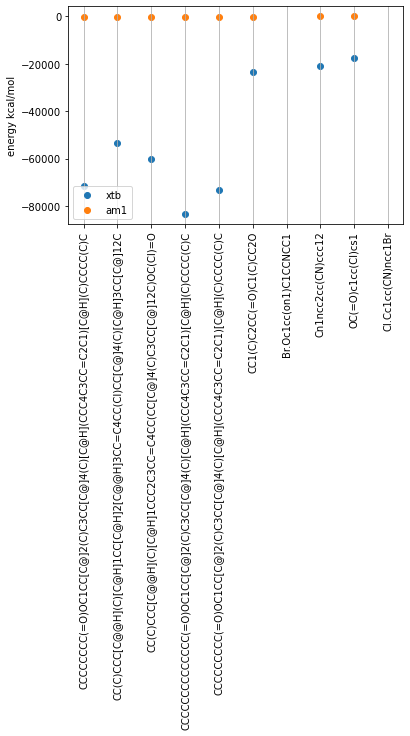

In [139]:
scat_xtb = plt.scatter(mols, xtb_en)
scat_am1 = plt.scatter(mols, am1_en)
plt.legend((scat_xtb, scat_am1), ("xtb", "am1"))
plt.ylabel("energy kcal/mol")
plt.xticks(rotation=90)
fig = plt.gcf()
#fig.set_size_inches(18.5, 10.5)
plt.grid(axis="x")
plt.show()

In [56]:
qcel.constants.conversion_factor("kcal/mol", "hartree")

0.0015936014383657207

In [13]:
# pickle the data
import pickle
with open('xtb_am1_benchmark.pickle', 'wb') as pkfile:
    pickle.dump(data, pkfile)

In [14]:
#with open('xtb_am1_benchmark.pickle', 'rb') as handle:
#    b = pickle.load(handle)
#    print(b)